Goal of the notebook is to investigate if markets were agents placed bets on were resolved correctly (sampling)

In [1]:
import nest_asyncio
from joblib.externals.loky import get_reusable_executor

nest_asyncio.apply()

In [343]:
from pydantic_ai.agent import Agent
from pydantic_ai.common_tools.duckduckgo import duckduckgo_search_tool
import pandas as pd
from pydantic import BaseModel
from joblib import Parallel, delayed
import json

In [5]:
from dotenv import load_dotenv
load_dotenv("../.env")

True

In [92]:
from prediction_market_agent_tooling.markets.omen.omen_subgraph_handler import OmenSubgraphHandler
from prediction_market_agent_tooling.config import APIKeys

In [9]:
agents = {
    "PredictionProphetGpt4o": "0x2dd9f5678484c1f59f97ed334725858b938b4102",
    "PredictionProphetGPTo3mini": "0xfc70c21a4a896383fca891120698d744d223de07",
    "PredictionProphet DeepSeekChat": "0x5e3c246778088546991595ee4cd958282586d8e1",
}
#PredictionProphetGpt4o - expected value (0x2dd9f5678484c1f59f97ed334725858b938b4102)§
#PredictionProphetGPTo3mini - kelly (0xfc70c21a4a896383fca891120698d744d223de07)
#PredictionProphet DeepSeekChat 0x5e3c246778088546991595ee4cd958282586d8e1

In [7]:
s = OmenSubgraphHandler()

In [10]:
bets_per_agent = {}
for agent_name, agent_address in agents.items():
    bets_per_agent[agent_name] = s.get_resolved_bets_with_valid_answer(
        better_address=agent_address
    )

In [202]:
# markets - set
unique_markets = {}
for k,v in bets_per_agent.items():
    unique_markets.update({bet.fpmm.id: bet.fpmm for bet in v})
len(unique_markets)

7441

In [27]:
print(bets_per_agent["PredictionProphetGpt4o"][0].fpmm.answer_index,bets_per_agent["PredictionProphetGpt4o"][0].fpmm.outcomes,
bets_per_agent["PredictionProphetGpt4o"][0].fpmm.title)

0 ['Yes', 'No'] Will any new public opinion poll regarding the Treaty Principles Bill be published in New Zealand by November 16, 2024?


In [34]:
list(unique_markets.values())[0].outcomes

['Yes', 'No']

In [38]:
# We use a cheap model with web search to challenge the resolution
# o4mini + websearch

In [217]:
tavily_api_key = APIKeys().tavily_api_key.get_secret_value()
tavily_api_key

'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'

In [370]:
class Output(BaseModel):
    output: bool
    reasoning: str


In [321]:
def get_assessment(market_id, question, answer):
    print("fetching market", market_id)
    query = """
Search Tavily and determine if the answer to the question below is correct.
Return your assessment as well as a short reasoning.
[Question]: {question}
[Answer]: {answer}
""".format(
    question=question,
    answer=answer)
    agent = Agent(
    'openai:o4-mini',
    #tools=[tavily_search_tool(tavily_api_key)],
    tools=[duckduckgo_search_tool()],
    system_prompt='Search Tavily for the given query and return the results.',
    output_type=Output
)
    result = agent.run_sync(query)
    #return Output(output=True, reasoning=query)
    return market_id, result

In [315]:
executor = get_reusable_executor(max_workers=16, timeout=2)

In [316]:
markets = [(m.id, m.title, m.outcomes[m.answer_index]) for m in unique_markets.values()]

In [317]:
def export_results( new_results: list[dict],
    file_path: str = "./results.json"):
    import json
    from pathlib import Path
    from typing import List, Dict, Any

    # Input validation
    if not isinstance(new_results, list) or not all(isinstance(item, dict) for item in new_results):
        raise ValueError("new_results must be a list of dictionaries")

    # Create parent directories if they don't exist
    file_path = Path(file_path)
    file_path.parent.mkdir(parents=True, exist_ok=True)

    # Load existing results if file exists
    existing_results: List[Dict[str, Any]] = []
    if file_path.exists():
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                existing_results = json.load(f)
                if not isinstance(existing_results, list):
                    existing_results = []
        except json.JSONDecodeError:
            # If file exists but is not valid JSON, start fresh
            existing_results = []

    # Get set of existing model_ids for faster lookup
    existing_ids = {str(item.get('model_id')) for item in existing_results}

    # Filter out duplicates
    unique_new_results = [
        item for item in new_results
        if str(item.get('model_id')) not in existing_ids
    ]

    if not unique_new_results:
        print("No new results to add - all results already exist in the file")
        return

    # Combine existing and new results
    combined_results = existing_results + unique_new_results

    # Write back to file
    try:
        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump(combined_results, f, indent=2, ensure_ascii=False)
        print(f"Successfully added {len(unique_new_results)} new results to {file_path}")
    except Exception as e:
        print(f"Error writing to file: {e}")
        raise

In [331]:
FILENAME = "./results2.json"
results2 = []
try:
    with open(FILENAME, "r") as f:
        results2 = json.load(f)
except:
    pass

N_to_fetch = 1000
existing_ids = [r['model_id'] for r in results2]
print('existing ids', len(existing_ids))
items_to_fetch = list([(market_id,question,answer) for market_id,question,answer in markets if market_id not in existing_ids])[:N_to_fetch]
print(f"fetching {len(items_to_fetch)} markets")
#
results3: list= Parallel(n_jobs=16)(
         delayed(get_assessment)(market_id,question,answer) for market_id, question,answer in items_to_fetch
     )

export_results([{'model_id': model_id, **r.output.model_dump()} for model_id, r in results3], file_path=FILENAME)

existing ids 600
fetching 1000 markets
fetching market 0x154ff535d43e2d82063cd94e6fdf5e61bb99dfa2
fetching market 0x155b52b5ec1218cfda4049e7cbd9939408fcc810
fetching market 0x15710f98db56892f9da2560d2910f319e89936ed
fetching market 0x155b293f517e60964b09168e3e03d8b95b27ed69
fetching market 0x1569be2c1d2428749227754c831f86d0e8a2377a
fetching market 0x159051fd42216850e804740c8abacb5c149bae76
fetching market 0x1584bca057f2dcb1bab23092d7a49a713f8faca1
fetching market 0x1595c1c2ed0e14a77016f449ff4a0ce67b313f66
fetching market 0x155a933cd1eeeb80ab6b5714c1ee4113590f2be8
fetching market 0x1592202f4c4118dc4abff9309372a9f0150c3b9b
fetching market 0x15c8117c1f3ec7410748862c9ff199641d83af98
fetching market 0x1567b2d0c84db9309cb60b72adaedb043b6ea0c8
fetching market 0x1578e902b96dc791df091b71a0f451051ed63322
fetching market 0x1554028a12d8245c7c27bd895a2b2ecb8afb15db
fetching market 0x15843261b63248d0e1ff45e6373612a695261fd8
fetching market 0x15aef98889b8f27bae7ae14c3e7afbdc3a9a2e4e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x15c84ab7881cc4baadae896a682866149be7e03d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x15cee27d609d5919826d999966eb8d70dbc99c4f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x15d7b5915c6ab40ec2ab5e1f77c6805d95f5e707


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x15dac2c1e077ca45072937a59dee3591aadf97b2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x15edf592dc3eb67e1c163ceb6d23039710cd67fb


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x15f078ad4ae6cc67c4041f0c184fd1340f36631f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x15f0c209a31548d286750d84cfb26dd6890767a3
fetching market 0x15f37a5512b523cd8f10f32ad4659db3b0400ba7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x15f8482df453ae793ac441f53b322225489078ca


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x15f95963e09ffcfaa6ba11bba286d8d8c46b7b6e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1603fa9badefd86a57df3798f79dadd462854fc9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x16292846b716ea7e2cc9b738e6b559ac24ef0b27


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1639997d46dd2f86cdd328c552af749bbedd75b5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x16422571063c97995009e38d50ac27064560e29f
fetching market 0x1647331878c5f42b3a5f5ef71bb95b0b518e90f9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x164c6bfd23c76a8cea403a086b184f4036afd9b0


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x164e69c0451b5fd8f8483b92ee878f399e6e1e95


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x16629773fda6fa32ddd47bfe4024a348868ea9e8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1669e81592471cc8dc1f3b43e3566fb186331213
fetching market 0x16813686ebae782dccd85faefc8b4f7f631d8528


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x168a01b446a33e62e56b4888112069b70e34ec69


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x169080128069e12ef70dd2c12f14e60bb44b3b7b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x16a79fb4d69b5db0f03896d9bda354e037253df9
fetching market 0x16b32d0bb5581056048968cd506503142050c644


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x16c0f76d9da0a9dc29d0185dc2a5dd7c1ce064b5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x16e192f6827d145b997977b0799e489fbf318c38
fetching market 0x16efe8334d5326a16696f4f3bafacaeb09fd209d
fetching market 0x17098f0b5babb69cbb715648628328071041a527


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1714df54ec8a2875a36152655e44847826e83973


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x17179201b206055ccedf2e366c0c5bb12610927c
fetching market 0x171a98dcddcc1cf1ada52e98e8629e48298382c4
fetching market 0x17242bfeed85a9d03b94c836940f2e61cdba24b9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x17258d67dfc89d1cc8848a98f1a5158b9cca3d29


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1736053c875729edcb3efca5f2501df419eb4dc0
fetching market 0x173bc9de49115bb2116a113416e19eada57ae6f0


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1740ea7e32dfa86097dbc9e76833299566a73e29


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x174245996ddacd70a360a5485485ed2e1e1531dc
fetching market 0x1742e4b9b8504554436ec2eb8195a8b57fa74de8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1757c2651e5f78d539bf47fb19f3795cb3912de5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x17689842a7164fa82d78d2b2a8628e8616bbf733
fetching market 0x1768f5defaa4dd744eaae82aa511c13eba20d49a
fetching market 0x176c78cde9e12d1967199d628d215638fb10e54d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1781941a78644d721a4bd1347331322f07108b7e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1783f75a969e0b8f73f8343ecf474c8787a744d2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1789b5c6508244120279c08d4f85bc9b6e47a7d9
fetching market 0x17a4f34ea4aeb8b11f91154effe6d932d0e29522


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x17b01eab789304d175cc9d58856b934acf306c1c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x17b4e1e086c1de494b373ea4ce2439bb6f90e223
fetching market 0x17c9d1e6e3c67fee9d083f5811a016b2b3499303


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x17d07d369120c9e0d993fe713c5a74f3aa4f2e36


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x17d595c70ae15e3a9960fa842595ef440a8139bd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x17dc0b3d55a44e5aba9860397eb2fd951b8b6d0c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x17de4f2778f7a5181708a2807cb69f537747683a
fetching market 0x17e1370d37ebefe29de3fa99a6ac4b8d13c1c04a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1804041273d304bdaad660186e4e9f0aa6e40a41


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x180f020a136ef5e2dd1d241835d6dea7526cb075
fetching market 0x181af80b1e042b265f0f14fd750a3b0fc176fff2
fetching market 0x18231191a6d9b352f06d2f3849081917dbba5b44
fetching market 0x182979236260e28d4ed2bda5bf54d34915beaef9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x183cb31abe811f328e7128ded268437377a73dd9
fetching market 0x1844a8ca2f47d13b9f730ed756b41c8baef67075
fetching market 0x184559d9e079d316258c3f2c46d905ef04c799df


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x1864d62bcb4a5ff8df3b903edd56792455cc68ae
fetching market 0x187bbc6df83cf39fdae63e27531d244ccda6cc0e
fetching market 0x187c822a330c393912398884faf8150d21b4a784


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x187f5570f4f96b949d93a1b6044c3e8a0351881e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x189a1be05fa096155782469bf9d6b7a441b83dfc


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x189b1a8defa63a3b64a61dee902c731f6e732d6b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x189e839655ceaf6f694ae617db16aed80b215195
fetching market 0x18aa3f703b6939b2aaac734da32540a8bc8070ca


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x18e6261e461498faca3d9044783fe9eb78cb6101


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x18e7f7e0f01797c74656ac8bc7d0e99240346faf
fetching market 0x18ea1272c75ea944105857db9b1bff44ed3604da


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x18ed0677e766de4db53177917c153419cdba7735
fetching market 0x18f1f66c80cf7957b2759cfc0a3286d68ab2fe32


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x18fa30e16d41eb84d147e87ec6d71db4d0c6192c
fetching market 0x18ffe7cffe15fc4f207361973353c7972a943196


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x19206a48fad8354459db9917bcc874b3398c46e6
fetching market 0x1924aa5a388c64fb62c7b382c8264d3b2f6e37b8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x192b421d527b19b118754e93542122aa546db31d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x19319d6ab166aef7f0388a447bec6452f40585d5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1933eba007da36b9224af9a13b486a1933505249
fetching market 0x193a37272310d1c4f7cf48e70b686b0f2eb809dd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x194587f90fd64724ae766c77fd892395dc34d7bd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x19481107351cbf30802e48f2e12b6587d4d15fa6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x194898af140749b63383af70fbd3866f0308cfc5
fetching market 0x194a97b3a4186d297a5069eb953f49b4a1faa3b1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x194bfb4abc924f61aa9f1e7c49fd689d7c428455


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1952b56378c68cb6bcc63bc53d87013536886dee


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1964a64931313cafda0a3cf9a93f9e58d5d43018
fetching market 0x196e124a88c8ff7af816fb22c9c1b6bb56c12dde


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x1970560c0580d5905372ed300264b5c0fb42ca4f
fetching market 0x1970646b5393541c2987efbd9a992ffe4769f4bd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1972c4a2b712eaf0efed89ab1f27a2ac0126dad9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x19878bd82706569db3ab1c44a254a683a3e54099


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x198a4192db7d709615b7f6903914e7c73531b9f5
fetching market 0x198fe3748240301587ff7927f7e908ac5cc3b223
fetching market 0x1994bba04ac937df002023fad64c2b6886363cc3


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x19a96f5be06c8e5dcf0e1bb874162caf288e3135


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x19ad1233aedf2a48f51926c28eddbaa495ede6e4
fetching market 0x19b7165f84792daac2cc04b5d703dc6b02925939


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x19be22a95c655ee17016d75718a08fd1d3df1254


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x19c26dcc663ca8f44a13e772c9372c76466ad8e8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x19cb08ba21c34999dd5dc8d2b6682396970f24fc


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x19cd84afa4667a51ef5cc78cd7364417444b35e1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x19cdd67629031dfcc81ec33d89d2456d9efd5cce


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x19d58cc081a5b663748f83743137e59f944856b3
fetching market 0x19d97fd477ad4b267b0694c04ed11ab775e45224


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x19d9e44b217d95f9488670009dacc59bf728ddc4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x19e611060eebd2100fde54c51a509aacb82e9ba2
fetching market 0x19e61831361c43eda0e18552584883d1ba9433fa


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a00af530c10fcbd1514642f17bf429b016b0794


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a0392664ac7549ef6cea18621dac5c41a995b1c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a2270c2000cdecfad79b63d64d85abe51bc7cb5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a25dce201683e0978e97e54ea18e8d4b71e5cc4
fetching market 0x1a26388c5460f358d14f2719a3622cb43f6aa247


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a2666cf5b71ab4b75a4349571686c02a3e3534f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a28691599a9ad17234a77efc65db769e4ebbb90


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a2fdfc294c9056fa2a17d0aab43c906580548f5
fetching market 0x1a3132cb3608c96da1914d54c23829564df830d2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a3a0044a72c9d1af4f5cc8dfee607a803abe892


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a4d5cba423402f545b4af892fa20f94ec45cd8c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a5155e98da67a307d72b9614af883203ef6affb
fetching market 0x1a54be98e1414c9dd1602d17f6b60a6a8e4ddba5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a5881fed12f0ce430bb033ff848d58278f13e37


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a593dd402aa09b74b0978aab3483374d71a78ab
fetching market 0x1a5aac71820f81e6a74878b70e3ac74380085d53


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a5b47292c58bfbcfb8267b8afaf5b2b8a7770af
fetching market 0x1a60c7a815a851261206a6c04cdb70d6b2d0dbfb


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a62c3d50bcdc0d0ba3637d75e152cc6504aa629


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a71f48d660e9f5e5132a32dd42254bfb7f43c1c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a77c0cca7eaa0f7f286a31cea3127b005288dd1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1a922cbaf06986aebb0c3c9b6679b51989aa8859
fetching market 0x1a9a9af01de34008e120b1710b4fa4965257b8e5
fetching market 0x1a9d28df02ad0b7c25c6c05fe9c7401bc17b401e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ab4c60868bc986ce4811aca70826ef48f09f9ea
fetching market 0x1ab8a1bf57c59f8a64f593647e89d0b65f21aee8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ad986440989c44c99a72d3a931726cc812499c3


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1af1c73dfa6de64cd1f6c1445166ae4b18386c0f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1af656e7758b2b745015132e3623fe91b11cab8d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1b1151fd5899c70b2bf2362389b9517913b286c9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1b1239cbb20725b761585fe7f35dffcad4e10173
fetching market 0x1b1648c514bdcff5f706979ed2c6c44e77a93fde


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x1b283357baf01fb5e40c7f962c0573fe0bc1a05e
fetching market 0x1b2f723f24cb217d97879bfcc35669be3325479c
fetching market 0x1b31ff3d6bdf02983a7292b6b5d57212fc957114


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1b3316560e5cd286fcda37149f65afd082265b00


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1b395759e1812140dfd4cf771b255c3018c04444
fetching market 0x1b40734af35f30f550944f0b56c8e2b1258f481b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1b4a6e436f3ae99608e65c96660e06c00053e6e1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1b4f4a7fbe057f047dc9120f890f50ea3609af68


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1b55de7199535130d2e3ecf382a662c84512414c
fetching market 0x1b6834cfdc620815b37b6bc0dee4ba22ed24f91a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1b6b337c2b5712ce986a027c1b7f5504a78ae864


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1b782424c59d866f4c6e739d86aeb68d0009459b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1b93917d75f80d14e15213cd41068089cb7492b9
fetching market 0x1b93a82f7b8c7630b54d4b60eacf60e78e669b91
fetching market 0x1b99a0513b89a206a23f7ea7735b62b1b4d5bc36


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ba10395c14c861bfaa93af0d62f3a47e0712d5f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1bad917b2dd882f105fd6a774a29d546f83bb727


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1bb5b7cb29db4f9e64631834420682ec2f60a92a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1bb8d53e8263fd963b21cec0f33f22786df29324


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1bb9c7b13c7dfdf3d85d9111aa44b6cf9df9a2bf


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1bc79ec15424f2d54769ff82987177a787c10248


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1bd7e55f3d3235a3e7e467178f2a34bf086bbc00


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1bdd848ae9044375c11b6ab5eddd2e4f9ff0f0aa


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1be3b79af379336bc4662dc17550255da3397fd6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1bebcd0d3801374a1fc0280ee2bfd96369b1b28b
fetching market 0x1bedcacd4bd8da966a36625d4f58c8ba8916d141


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1c027f3f19ccdd3ed5615e60783dcfcc5228eb06


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1c166362fb90b1b8c5366044003493a31605e8f5
fetching market 0x1c16791dcfaf6b27d81ffb8e0747e101bfa9e1cb


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1c24396a9dd03870192186f54d396ff4f6ff0615
fetching market 0x1c3e7c43961ca2e9278fbc1023a8bf3a83c6f4e5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1c4cc4da9e22881e1cc3dc259475c8115761df4d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1c61575604bdee8d5fe8c2d0c9e5e16fd9dfab7a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1c61beb9886771ad982b6818f454092eeadf4c90


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1c62ef0492cccc5b9370e73c7827f94a4142c5fd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1c6c8d9d082e892dc9f80684c87fd7ff391694cf
fetching market 0x1c6ca7bc666e57c61a27fcf57ef6348fa3f5810c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1c6dfc1413af06fe48eafb6077ad04ef62321426
fetching market 0x1c825bdcefa796673ec26a5d948f590b2ca8011e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x1c8b356f76f3c14d5cae24582e2f5e7b08fda114
fetching market 0x1c9c3d47c77f156f458aafcdbd84e5dfc3487a9c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1c9dd7833cf55255ef5f98528d38b573dd5614e7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ca525008a1354e941f35ccadd0d1895c0b02d84


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1cabd633d335619aee41ee9771d8b25f8c4e586e
fetching market 0x1cb3504c5ea8329a510de9a4adf0612ebd8f10e1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ccb644f45863ebc7d4d35281c5ee89cda7d57d4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1cced4de279ff176d94880eb3515bd3b467a509e
fetching market 0x1cde9ec791a7f4fe2b9b95ae12add0a91734f2ec


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ce3b15600b1a045af6dcadd088ac52255535ec0


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x1ce62c41bd97cb197d15f234ae59240ca01e44ee
fetching market 0x1ce9bb5f54c8688b25aab82eb2eebfaab576825e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1cee5d5a5669291f8738eb37950a8d4cf025a625
fetching market 0x1cf6db9d9c34ccdd2533034cd9138473c53fb4f4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1cffaf06ca33b90e4cfc0f97f19bde392e7a7129


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1cffece3890566bbf6d29e532d8adaa41e4587a6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1d008ca74a6b7186039abc552138140fab65ee4c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1d1bbcf4b2f5f7e96dd1628f0e2c67547da5f321
fetching market 0x1d1f219a2818690911d5817b8cb4e2dfc0a1147c
fetching market 0x1d23f5dccc070831b5fcc0008bcebcbbc671136e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x1d24d4a4a782ef64cb37ed7534f57fc5ddd4d821


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1d2a6efb84d97820d8ab3e2b97979261796e8c7c
fetching market 0x1d2f5c3d6df669df000a473394930f72b3a2e94d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1d59d87374ab4b18b66c1d5020f18e7d23b4bd72


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1d5d104a8c78c437bffaf159969427e2a7a3ca1e
fetching market 0x1d64d9370bbb91b21110e4bc203a7025c8648303


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1d71b052e23abd96ef45a03b750188b7bbc54e5a
fetching market 0x1d73e12ab90c5d4e5d554b4b2ac468bd74e4d887


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1d77d7f391ddef22cf9f05dbf609496e015892ea
fetching market 0x1d780c65532604ad19f9fe31e1038d922119c748


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1d7b87cbb69bac3ebdf245633c7c249fd4474701


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1d7c76bc561696cf66c010e66ea035347e7491a8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1d86b8c59620ea243467ff2f91adbf0943843008


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1d965bac458bcaa949778b29dbad754fdfb18520
fetching market 0x1daea4c898370a10d3b8b35276af16259c4716d3


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1db63880548f480294c0de9afe7b3a3632d7d847


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1dbe6da63d5b0fbde3e8d1a2249b4cb81e618296
fetching market 0x1dc2b0a2ec71cc0927b6ed61f37643aa2686b15f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1dc6b2a6c3140e8beade4fd60be0dc4c6ebf71ef


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1df0fec8acd0845184f0da896fcc7f26e4abf411
fetching market 0x1df61a0610c141f179c9df6b135b8975cbb12dad


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1df9beab40698264dedf42c0034f345fd0ed72a3


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e012b8ebf4da128cbec9eee65ae170b9d564051
fetching market 0x1e016dd31ef3679212fd4702d4ec4920821edb59


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e0e1d092bffebfb4fa90eeba7bfeddcebc9751c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e1ab8d6ec3b932bf0e1c2e2e8693b3a431eb31c
fetching market 0x1e2bd99690c55d0c2ec52e83895e930d70bad018


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e30649c8c69bd2b51e5d533ea3ed8156aeb69fc


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e38bb22337e5378814b9860d4be43919121b8a1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e39309d0f2d5c4024a4db05444a6f14197e957b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e39944fd486221b95131e804b53104f91481759


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e3ea20e1f1c6a2f04df1ca96f601a11e247125e
fetching market 0x1e3f85b2f752a3ce1954ae0f5474473a79e431fc


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e42e217cd41396da7d437c8b4eebb7b66e9d108
fetching market 0x1e4618fa7e7e4e4ba617c6787626a779f84fee93


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x1e4651bdcfeda4002d4d740105fa8f34e59f6fcd
fetching market 0x1e49c0f86c087e3ce2bc6258d8da8cb34a94d100


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e49c1512356ceed4c60a9739999007b961920b8
fetching market 0x1e4c4f035edd42fafbd72d74a713664f9ec63a68


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e4e4edde22b77989613bb3863482a062a70d127


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e5864d3017112c275f8fc519059ce4b9689173d
fetching market 0x1e5e9776a319d2b36130069298b436f03484f80a
fetching market 0x1e5f476911f78f294e1029285bff8959bdd0c5ae


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e6d3a967d1d399bb749e6317a61e8afa1fe8953


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e721ae742b9abfc92328a4f5481efeac1a35e50


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e72dfa4899119c5c088a753a5e645dee78d7154


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e7989d53162e0a63c33f89e7a2666fefe89c1ee
fetching market 0x1e7fbb685c5f4cdc44f6f426995905e7119a8008


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e8bace3c880068c5ea28565f04c00c0b84a8e1e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e9413b7983ff3c5d7ef4856398d08f0d6699bc5
fetching market 0x1e945ef9013a61a5fd92479a78da27da06313848


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1e9813399be7ed218f7169632bfef5ce232066bc
fetching market 0x1e99714f9059ee224618e212f26f4a3af059755e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ea60cbdde106a6f408e897893425966dcd5208c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1eb4d241ec4c7f64d915a398bddc36652de87cd8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ebabe5e45095d44b8efb40bc25acf82215f35f9
fetching market 0x1ebb36703b1717a888573b53c1582feaebcc95a8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ec0c333058d2e3444c283f9368e90c9e7121957
fetching market 0x1ecd2fafee33e19cc4d5a150314c25aaeca95cea
fetching market 0x1ecec9252ca6e0e264d41e05b61f732b8f3fc663


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ed5fcc605a3c10b80d3a466dac20e4c82e16df7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ed6acc8851af2f7927c5fa7bd3b152b5ed4b4f4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ed837909ad8691d71b38361aea00ca455a930bd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1edc3faa65140071c21a41fa520eec176b2caa45
fetching market 0x1ee72e749928703b5b3446bf8adb81c01f612d92


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1eed3912e38b500cf0d4bf232c0e90c78e11435a
fetching market 0x1ef040dc5119a044b15bb43697c1d8471bb252da


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ef2fb4e493745abd67626d50affb6b895bb5ef7
fetching market 0x1f0841d55c6275d9680fb7f4ecb41ab781671ab3


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1f0e2dc31abdfaa6b9b7d0c91ce195255012d121


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1f125721568226929907a9bd14f13c608088635a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1f1d868b7934ccf6194e9d0248c536388cff1e8a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x1f28c9aaef48a87f760cfef669e380eaf32bdbb2
fetching market 0x1f29dc2eec5574eabc2918636eb109ebacc205e7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1f32f389890577f2bcc6e63d02eb0fa6d73b122c
fetching market 0x1f342451353458635e15583bd0b6755d49574775


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1f3aa22a191445d44288f9a1860cead07bc42920
fetching market 0x1f40cfa0fdcd8d628b7703b6c2ee01214bcd1587
fetching market 0x1f5da8b19372937d9401b9923974e8af2a7666b4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x1f6558b48678e6697848b850734ccc42b318b933
fetching market 0x1f66aaa509232b2e8e2c2601c5582e06d3e1d7e7
fetching market 0x1f6acabc742d1efbb45117e653b3639d5d326324


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x1f6cfd89f4d7576dabdbf7844d33d8130665b6da


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1f7279daf2bb534bafbaf5e66fd074c2b271eb73
fetching market 0x1f7320163ebc02ee56b049ad66f0400b0ca6b04b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1f9653e6cd0a6fae0192bde5b98e67c33183d597
fetching market 0x1fb19a0b70a723c341a8ae9c808f9da7aa244028


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1fc8464242a0c7e09487430fa2937c21379cc3ca


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1fc8bef765efc8f7668e5119ec04b1d1586a6051


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1fcfa485d1b16241c5e7caeaba60ba5d0f7a9df3


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1fd7df0f20fd19f836ad3bef7b5b936941781682
fetching market 0x1fe3a878505a221ca8a45b7e0011a4c55a7f348f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x1ff5ee0c1eaa9ce3b0a7e3e65048c93deeece4a2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x20106932315f8b2be065ef8018e7fcce6e06cfcb
fetching market 0x2011bc5f3a65ed243026295019fcd38606686039


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2014e2312669285c695592b664f869d75400c13e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x201eb9a269de94a4b08d12c77c0b5036af1198a7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x20274cc4fa71d8cd7e8ce82240980f3e4a304428


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x203406827c7a4fffcecadb0289cd19095740a499
fetching market 0x20489a059754f7a5d4d90ab56e5014aa6827a528
fetching market 0x204a549df26632d265555e7b32ff173ce6951908


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x20624f478202fdfbffabb5553df369008dc35632
fetching market 0x2065a34939a039a62b09464fcf10f81594705676


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2066efe380b4c03340276821fd3ae73a863a1220


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x206aeecd2f26108c12863166378b707dd29777ca
fetching market 0x20735d0cfc4d5b214e6471231a34c903021d09fe


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2075db6ce0ccef4cbf879f37014d763085bf9115


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x207a5277fbe010ee42d78427e06bc490878897bc


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x207cd00ab11cb69337f6829645f1448377b2aab5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2083b1cb5e82706d9c9aa6a885b4c119ae1c9645


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x208b6860d6ba741ce11dad882b654d7cbd2948a7
fetching market 0x208bdc954dc1c9a32fa9bd3f08a8f7e4c1dea73d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x209a318ea21cee93d80673d27921d68b7f5b46d3
fetching market 0x209e22da3113b726f537a33e3e99a51ba310cfd4
fetching market 0x209e7a357d29747a1e414d7bce5eb6a5af65c195
fetching market 0x20a5462dcee4652c48573c3189a5c29acbcfd56f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x20aacd6a62b82fa14956fa9d8bdc24a17f02a63b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x20ac3282f0f3a3a01772016609ef744cec4ea28d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x20acee245b80790b15bb717346b64877283edd8f
fetching market 0x20c4a07d1189e75bb3508b84f11ab9483f5397f2
fetching market 0x20e35fe811e6e4938559f251e7b22261df2bcf04


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x20e7696cc7632d27fb6a7f5ee4bf5e05467c3c03


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x20ed09bf1c02a106669d2ce2e6e1cc49e97128ca
fetching market 0x20ee483374326d7823d2848eaa48ae2d1bdb95e1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x20f1e63ee676055ba53480781ca4842f3e609894


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x20f7a1683e55c3a96103107037a2a3c9ea18e1c6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x20f93ad990a3762f75c6b7942bfdc9fd6295f0ed
fetching market 0x20fccb9968608ef6cbb419bd519af676aa704a9a
fetching market 0x21058ce78f7d0a4af9c258de0f70506d71b34f7f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x210abd989eddb42ae027ebd29f94f7ba7ea1a4a5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x210b4f00d52888984b7c1b43e24da9f06c69caef
fetching market 0x210c604e39eae595cfb0209ef4bcbbaa73a94df1
fetching market 0x211427ef5e484e7d695a93e9da49445fc2d4d5ad


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2126661b6a294ab4459afa21bb929f0bdca2c2d1
fetching market 0x212b16bd8cadd8f78cebd4f487b082e787199a8b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x21444bfe14c6bc380cdf40c107177193d7aa6752


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x21485eeac4258364a35b70a414448ff0b73133e7
fetching market 0x2155540d326814084c4a172e238ec00f06ea9d85


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x21574419c4fc8f695d4d1dc6c83c1b2abd56f467


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x215a4385bf2b224e0a713e86574bd28db6bc3983
fetching market 0x215cefa876f42c44a6781fa91c9ba078f08feda8
fetching market 0x2177fbcdcf8f62d1b4c0c65b8418f0f546234d2b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2185b7947e8c789313cc43af7a4a51d3bae98499


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x21906b8be84ca780f3d5f9f5dade946a8bbda452
fetching market 0x21a27821fc740ddff9c88cae94ddfb258a53390c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x21a93a1173ed2ad4dc07466e607688cd0992b575


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x21b50c84b9d5aaa28bf96ac12e1b08e51cf8ee34


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x21bf1a96f79ecf8adcbfbe68d4cc1a4ad215de0a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x21c170f273e48eca736e0aaeb8b9da443729ee65
fetching market 0x21c269d98ac3685b5a866d01e44ccd49102701d9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x21c54b4f926a313d0bbf4a49be7d5094d585f5b6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x21dc48a7ed05d4300225dfd339648ed020c36530
fetching market 0x21e8639e27ee4934cac0c7302c1e67fea20d5559
fetching market 0x21ea7a4381857ade9a2eeb74fb71450af5f5c05c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x21ecf99cdc2a7afbf02afb02a72486c2c8722f62


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x21efc8c637555c8c7684dbe55001673e5813a2a5
fetching market 0x21f62b1b034058de0c0519188336cc2fabf4cc10


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2203e9ee1204be71b6af1440ebda6279c1b568dd
fetching market 0x2211f9445ed532f0cbada50f7e502c12dc520b26


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x221783b911d54597660e87a0d2bfd87098517969


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x22268e4531bce7ade44f4d583784b5fb59cc4870


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x222f5b8e100f62fd4240189838deb2bcc4e05ca5
fetching market 0x2238cc5bc6cccb26fe7c82d46845cd0c8826679c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x224491822c4c1439b58147d963eca672d467eb02


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x22637782202b71484ba3cecff9d95bdd25afc0e2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2276013b0b2b5ed0067d519de5d2e1d7b535050c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x22875ab3d3898b959f15d58526ff4a65dfc8dee4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x22a77e150345f42bdf2638edfba5665c7ecdd9f1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x22add4479e406a3a36f0851a9d555f1970fa8bec
fetching market 0x22b10f8ac1b54c5cf8167993993182002e25bede


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x22c9719a7d400904dab4e1a32e845cc405053c45


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x22ec385c716421106e0774605839de1724c61e55


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x22f603fffbb34b987497eb33be86c1178f24d48b
fetching market 0x22fb392bd47f29a7499e43574eda370c3d190c3c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x22fded5d9c2bbec5d726910c828aa964ef83e3e5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x23049ccd84cf3f211b27a39784fa2ddb7dc7fd95


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2305bfacf977491ce8bd8f2e6a8acc25deb70c88
fetching market 0x23096b15be8d2dbf3fdf0e5b055b2662a3a9fda7
fetching market 0x231d94428324d86bf83e8ad54ed472ac0b0c0572


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x233275cd09ce65a0069b43b63c0aa866a6067cc7
fetching market 0x2332aa9067cdc569c46a3da2e33adfea9e75304e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2332d6592c9db28d4a0aa695128bd48526983466
fetching market 0x2333dd337ac6870d3fef50c9ce59760b0ae74e62


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2337a8ceab4b9ae20feacfc09911e1f07e1a0e62


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x23380ce0da5de31f3423503dff1c8b2f4b38bd4e
fetching market 0x234325274ad9197f7eab68726d89eb261e3563ce


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x234b24ad6845512d5fab65c01f20bd6b68d9e88f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x234f75e2151e0001e2df959e1b595091dd042478


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x23653ee15f89410dda64872692091284795f3813
fetching market 0x2379c39b63aa1a3e37d4a7e4b909a699b4c14a81


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x237ada58ffbac1749b4ba28cbb8da9bd641a4a73
fetching market 0x23822f354dded535609b73aff4d69600ac571091
fetching market 0x2385acea06516d895e82db5af6a7eb19bdd1ca6a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x238d1be4f2f232f21650a2da6121f73c3c840f16
fetching market 0x238d498f43399fd1cb2c3d7070b021d7bead6350


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2394f973e754b59e39742e2c2025b93db4020c6b
fetching market 0x23a194e6bbc31accaa514cfa118c64928b84d3b7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x23ad4db5e0f7fcd09378d3b0b946b81e78035198


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x23b63567efc84784e303c42428967913743e0abc
fetching market 0x23bb0c11bc962a8719c0497a4ec64b8ba3ef183e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x23cca894020d06b647699f0978a239a8d15f503d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x23d192ad785bc895fb8994c55e3e19daf186e4c6
fetching market 0x23d72e4c8e743d4cbff37aea78d104d42093c20e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x23d9f0005206661b6947888e505634fbb88c6f41
fetching market 0x23dae96ccffdbd1d48650bb7efa0890d766b666e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x23dee06a4f203dad8eba9206c46e45043209a7ff
fetching market 0x23e8c3dc46c00e20c3dbf0ba0ab7b98cb367ce7e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x23ef6aa47709da82d6ae9c075dd7c5e29a221295


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x23ef914890f9987700083f3b35dbc28a5822937c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x23efc09eadd07edb22f54800dfb6994f5f90db46
fetching market 0x23f650183aa9693efd8dbfb371f3673a0bf79fb7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x23f77938089a3700eb7a8336fcac8645e3cf6577
fetching market 0x24012f8277e87a1d545a1be3f51145d60a7ecf49


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x24083ad31eb23265293fd9807bf57ec3430616a4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x241d212b45ae3ecb2809421df1f3cff2bb2988f0
fetching market 0x242231ba141c60c1f720367f35ad6cdc2db78211


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x242b3540262ca8cd6274cb2cddc7ba75a6b48cd6
fetching market 0x242e09af19a274487f418fe3a1fff8e91b64ed07


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x24318738b3d1e7c6b52c7290f7d17ac0d50baa98


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2456163c7cb2fcc1982f48741a5a69372f563ed3
fetching market 0x245b1b25aa62caf1b9d4379e7dd393d47e3fe0eb


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x24656647748fd22aa28f2d675478d0347078a7a1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x247ab89a79d25e37f0b8134dd3cabf603ff32255


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x248a7d7b024c1a2f85ae7747f8665d5a44655241
fetching market 0x24a57d29d927fa492121439d4622402b7b181d76


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x24adeb342636c2bd96260e2be1028668bf6f3f08
fetching market 0x24b22098ffa0eef8abfc23104d2cb48636eceed7
fetching market 0x24c1a9911b4b9ec7fb9727ce6844def99cae81d6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x24cd24611a8d68c7a9006fa125a350df1487c1a3


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x24d265423c0dbb3c1558d2afdf76f0b42061618c
fetching market 0x24d9f9208db34f48829443fcf407702bd9423248


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x24db054c447c791a864237829e06696f5d0016f5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x24e72c5784d38518ed40cd4b61e028fa3014f2f8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x24ef83330caba7af3e70ee4e0356b8bf678a39d9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x24f29bcb522516e7fc22ae2d7183dc2db84ff13f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x24f47dca762a5cbb925cc5dd063fe8cf9e94fd3c
fetching market 0x25046bb447a1e68ac70cf3a5a8ede7fc8901f2f5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2504843a644fde2fdee946312eab2ce74dbdaf73


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x250818ac3b65b82867c2695457f9670e60c5a99e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x250d14e6ec427cae578ede8f1f6bd3948967e3b5
fetching market 0x251323ee3b3831e9b8d514c7c2f67e2fc2242858


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x25197667ed41a84adaeb7dc8f1629c48f737884f
fetching market 0x251ced39bdfb6123085657dc95b8e46cf9631400


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2521570d2855da52acce5282330f9ce366b493cb
fetching market 0x2525dfb25687ee7cf25109a40f0f93190db83162


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x25408c25b8681e994e2e12c6754ddf446124cce9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x255491436c4cda3b70dd25877cbe42ba0271f636
fetching market 0x2556fdabc9aa62467aadc257f5d8ece0c5823523
fetching market 0x25613a76f9d678a7e6ad1e40cc5fd181af9b5fc4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x25715c7ddff026727959dc7616940722bc6fe9d6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x257d2c6f0a12425e2f173e59159544b3e7ed7047


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x257d651ec24370921d15104acdf5d0ae0c972e3d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2582378b3f612b01ee358e59e2ff0fa2f669291c
fetching market 0x2586db0706a167fa33c898e9136f248f47da78d4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2590239ab05f4887459056c615448aa8774e1739


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x259babcc5b3edb04c889bfe634cb10dd69d7db70
fetching market 0x25a573abcf0ee0abad533a1cea3cb5720ebd9183


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x25ae2e145b163ce1193f52f8deed7b7a62fa82ea


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x25b2fadb3d6c549745dbef988185f656372e1e5b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x25b805bfbb6bc042ec182e02442ebfc671c93b02
fetching market 0x25b867b4bb1404c1e893483f1942b4e9d0d29dca


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x25c717ddf332477e32899cf47dbb9ef38b22cda2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x25d14d28deac8946f5074e2c64917fd84c4f533b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x25d2f42cbcf056dd9ed233745efdc29b040ffa1a
fetching market 0x25da4910149ea45b75d1bc356eb6f3e7c7ff827b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x25dc1f19702ef63e040017746722158cc9563b69


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x25e0734828a204b03d0f25b22db4f5dc611d0759


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x25eb90121b2d71baddf3c1a12329313512b8eb28
fetching market 0x25f6f8043cc34d6c852cacf6486dd8538f343035


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x25faa4052100da90fb5118983ec65d46b095db22
fetching market 0x260122557e0c823711db768a727bc3ae43b063ab


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2601eb143bc65dc377a58f9183a52815aa099a62


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x260b79015f47e806094f5a55e18fc313c9f1fdb4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x26109fa28291914eda994c57084f942f678b2113


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2614d47c673411b486e4ff0dee1541556cc0853b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2621749112c9ed4d7b261b57b341a5fe15bf2b2b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2637509ce0842cf947a91f0d1e65aad7992bd059


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2639b173d8ccf4d57dba57f98315c907cd8002c2
fetching market 0x264358624d1cfb5b12c3719fa648bab9a25e365c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2644c99d7af8b633f26f78efc1c91a55873acf01


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x264e5a6dac8a970495bb87f6d84e23a2e54a6450


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x264f08fef80eaf8ef5a37d7f8d8daec9acd9b319
fetching market 0x265b490c4bb40f3f3b7523a3b8b16a9790877e24


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x265b54d5037742150c473ed1bebd3a46e5810618
fetching market 0x265d4cfa81cbdd8a79d1aa0d94b88d2f86c82b5b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x265e2695b1af6b5d134adec20beb0d0739e3a539


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x26765f9afab1806d42d3748f0b991d59e1bfbf61
fetching market 0x2680a0b559c05b991a326176c4777e1d0024be6b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2680b3d4c9ebff6c6599f7a32f348dd34b9b2851


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x268ce17d433e6388c02a4c6598727a07caa11c3e
fetching market 0x268fd84b122da252ff761fedf5cab7aa40a421cb


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x269463e498ea81120cf8d086761841921b9b65c5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2699a4a179f09a9b8a96334db3e40d9391438e6c
fetching market 0x26a50902923e45fe155ed962285a428c3d4a7eef


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x26b87970fd50462578417d54494725aae3511fc6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x26b8b6ff1a04c9fbeaf5c278bb56b3967a397a7d
fetching market 0x26beb215cda7e03ba18a0850aa4c1afeb2d6e168


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x26bf1174f354c4c51b5c49a3b10fbf48a9cf00ac


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x26c490077e9636d03750d5a85caaaa04edfce073


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x26c56157847d4eba518d7b14b0a6e91ff94e4781
fetching market 0x26c98037dba74e4c9570f507303665a3c2bc0683


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x26e677ee660071bd45a5c7cd52a0f9e6971194d6
fetching market 0x2715ff2a3eed7a2a41f70ec13606fe290be3436a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x271aa2f8ced8bdfe65818ecf72ab6572c2c7b586
fetching market 0x27213e7caacd55d199ce8bd56c513dc21c854862


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2721ed6896fdb65f3b866c62b2798b54be4c007c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2728e8be4cd4bb2cc37d5eecb09670ec10451647
fetching market 0x272c79c3a13a6b1b908c7f905100024ac347770e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x272ca7591e0020006c6440c460377df375897cfe


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x2735b4be9aa3f36098b5393ac5c05fff119ceefc
fetching market 0x2736e0a94763f4b7aa58ef14a2ac513089bf7dac


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2736fadc8cc1dcd1cd9953765b9989e152cb2a04


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27380b8b78e5991b55c454666f9a0ef50621c4a9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2743a04fa1950f85762330329990bfa5e208e835


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x2744e98758026f1d80bff694c11b62333227b26e
fetching market 0x27466feda74b2c9eac8468de491121fc64a7c385
fetching market 0x2746dbbd80cf0257f799ba0a3d24a055dc3bff45


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27526e3621e32a1b68819a36f31b40db66710049
fetching market 0x2760001299d1cc479c45acaca2d9d515d0128846
fetching market 0x27620fc2bbf4673558419a2500a96a965b96ddc2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2775080c136f55ad50110bc21808c924e2991e23
fetching market 0x2784838a6ff641f44132c5d06500cc2bdc2495b5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27866002204f3c1aa50c725fe38a0c44445cf258
fetching market 0x278c405a8d2ea491aee9b632adf4fb912b579877
fetching market 0x27915d755ab1f595640d38dc7d22a9f944026209


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x2798126eba36c75911f2c332f711f124c0bd45e9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27a2666868f73a9e01b8dd39a130a2888a88a96a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27a80e87dba67c22254dbe210244c80e73234b3f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27a9071541adef8fd8f3f66a69379d7583dda3b8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27ac25932ebde4451a30bd51bfe874f51d31f8eb


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27b559569d94767c946475cf086dfc19dddfca39
fetching market 0x27ba2b6a3324754497dcd8ab718e03872ca7eeb0


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27ba7aef7bc550ea98c28d5b75db3fd0f40ef13b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27baeeffeab648e2906ceba35857f2a377054d7e
fetching market 0x27bce1dbbfe6f18841e9330b2e7493de0454c026


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x27be5f35f0b16c5776649eefd1c45b421c5c45ab
fetching market 0x27bf2608793174288760e848fcd4e8e923a119e8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27c40a57a4aba3bd48be6b359b154af11d23a57f
fetching market 0x27cc4c9c4f25580ecd9f00386f664c069bc982bf


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27cdfdd2a9b3d88ab975edc715629e190d60f1d5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27d122ac73cdf80e1a2a66b25763d6d08effe6a9
fetching market 0x27d91754a59b604d7a8f07bd84cfa754f9a4375b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27ee991452da559d62237deb4ac2191d0dada5e1
fetching market 0x27f0e11841994bc0c27f8e87648faa207fd713ce


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x27f448a5f88d07ad741f35a26a237710a768e763


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27f6c55a67fd933a753dcbda1413a14beb40e0f2
fetching market 0x27f929580611d680d332869049f52b9e333f32df


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x27fd593305d6b5f85d98f454872cc3ec32c5f9e8
fetching market 0x2801bef3face753044ccc187f0a365cdaa7f36e7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x280339496306f08644e28299484987758afc49eb


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x280d36fe862fc003716fc872e8d25e74e16c6a24


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x281210db08a0f0c5fa16234ad9381544e5240f04
fetching market 0x2817bcc4cde7202be27d8b7d409577d739ee304f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2819bcecf402f17c269832488caad5c7d6a2be57
fetching market 0x282635462ef7b63b891ff6f53eafccccde71c9bc


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x28328476810c9a3fa742ffa3342bee8e830bd2dd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x283c0377a8e97cffb98b3b9a6b64598d6ec87b37


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x28447266a0a569f4a2700255696a931865699a1e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2844bfba201c09dbe475fa292c39a3d79de39028
fetching market 0x2844f85263317b1726709d5f8f35cd2347f4424b
fetching market 0x2845e966abb4efa741499d9ad356bfbc2d65b91f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x284e13c537d19d8f6a95f80bfa148c0a31b2e2b4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x28581069fa94404a1cd57e1a5147cf8557cf5000


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x285b3f8134ee8d301602906469440dfec65eefae
fetching market 0x285cc18eaaff311faa4969d9ef842dbe460ae7e7
fetching market 0x285fb5760684f6bcd2dd5fb202ca10ce82654655
fetching market 0x2863adfd066d080c8ef249bcdbb46be6a3020011


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x287da8a6aa0318d8bb747d0ba28bad678d0e6525


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x288da6d56eb29eec9bea93a57b4bf97d9bb82524


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x289a394edd3df4133d4dedf76f4bc18fd1a936dc


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x28a32443ed0e9a78de842d91690f6a941e42b250


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x28b65bf1245815d15ca080d41b944273758ee377


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x28baf83704a56b316d4cf49a841fdaa899477a3e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x28d1eec63ca71aac404d32329b3b4bb49fa1490c
fetching market 0x28dc27174ec74ff3581146e9dd8a75dd9cbeefe4
fetching market 0x28f62c2174a9ab6c8cde3ffde2f7f3f31f2d36a1
fetching market 0x28fc052cf4584c86c7d3ff5c201f61370cd55492


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x28feb438fe3a763691de0259685d471ff247919a
fetching market 0x290328c892e0cdc1d1f7cc6e5f9705560d5b7d9a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x290df849f92cddfe5b90f87678e41a60db3dc75b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2915134b79182afc93dc1d44247b7570db720cd7
fetching market 0x2923e5949a888d76d9e98c546114ead87b030e04


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2924ea1cc0510d6201738befcfcc4b3864866cb8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2927521464a6ebb5cd794b25695a8e2280f2bfec
fetching market 0x2928a6f34b4a03493ca23035e7e79567f6334f99


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x29351129d4f00f45e1d3d183ed13a3653abffefe


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x293d9ac369ea8eac5f1a758b0651c4a6bbae3de5
fetching market 0x29462bf8c8f24772cd6da03878a4aee5c5813474


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2948ae4bf3f6413348670423d7288a5b06f1fdeb


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x294c59fa135e44dc291e0c02a894744dba223959


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x294cfd5f2f863fa8d5106d5b45dae8ed099eb815
fetching market 0x294d39cc6e2d1670ad558c7572c2ba6f6bd5e5a4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x29512a022dcb54e4cc194fbcb50c86caeb0c6695


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x295429653a734a1e172fe211ce1205e948cc804b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2956343b2b9d12cf852e5f77d0f40dd5d9134a64


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x295b98f95c8f0a49825c1c38aabf0a24d47ca47f
fetching market 0x296d04504c16529908de0522a8694516c24d54fd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x297cbc2e3d8fdd1156872a7c4c43b10ff9948e47


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2985e3b7e89253e468c65dc60c3680073a6be658


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x298664323a4d9f0b05c05ad2c0b57f2f0ed41531
fetching market 0x298740b552fbcd96bb990dfffc679fa790bcb369


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x299c92309f07e1fc892e9679ad4f55ae2d23cb4c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x299caa48ee8ae12e08b965605b6bf66807cf71bc


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x299efcb17b6e658d467a9cd551be135aa2bf51f1
fetching market 0x299f3eeb4482b9bb31a43c68ed515faa01f5ba44


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x29a5d50e33e47d99aaf39c45652b2b5f785b8e91


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x29b02468d69ae8a5d468cfe7bc65fba4624e01d4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x29b9f881ba0b04cae93a6cc8e762ed58ab2fe33f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x29c41f4734d92c196ecbc16ea09dba35128acf22


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x29d21c260dafe3bb28ac2718bf9b0a825370f432


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x29e406447195b4ef493f21e3e473198f1c47aff6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x29e434110f9b56acce2bdffc492559a2a06cff1a
fetching market 0x29eade2d0bd7f342be2236dd9ed9a483e7326267
fetching market 0x29ee27d29b147a2ae0ea90bbcff31ad297952294


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x29ef23c575a0f670f7fecefc9fdff449d12af152


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x29f298057ae035e1d4f6b28277f259becf815eb6
fetching market 0x2a078426e944af106d110dedde64c9927cf0cc7a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2a1712c37e3ef709903e11e820a816cc5e542b48
fetching market 0x2a1e5f3e8678d202569f2e696f3f6c99a03afa37


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2a23611dcbfee598f45179ab6e33d4b00d3b3b8f
fetching market 0x2a2fa8fc6caeb5e671058ea94bab5ccfc977894c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2a3779ad4c37461b4de3e850e8d536f7cf964f54
fetching market 0x2a421a575bbb407efef73890c3386f7dae18cc00


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2a50113476ebdb6f211d9ee1b7b3285c4539d62e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2a5f7225a4dfbd5e35cbf3efc4ad65cd66054688
fetching market 0x2a640e8a24b93d28bb873f88dde527364277860b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2a6cb16f4b9e939d98626be7d1dd4c1c640b11d7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2a6ea91eeb2e403984f9a401a66cdf51f5b423b3


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2a7d27000e9d17f694a10b0658fa009c844ee2fc


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x2a7f38bf883db528a932d2eabc4014bb54a53c66
fetching market 0x2a8d590d7e30586bbe028f2bb3e4292755e144da


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2a8f795395e96347f6422d9058b6b369692728d7
fetching market 0x2a93d22bfc207ea8109952a99a378231158f1756


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2a9439d0ef3b1905a4874182362b05a8d7cacb46


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2aa9f9f0d8f7ba4bc9b586c4b301f25f6dce9dd7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ab11fb09a0d03b38c863fe6a99304fd53c3779c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ab1a84083bfc5c3b2db0e96c62dd077c9c8a36b
fetching market 0x2ab354a4a7fccb2fb8459fa8513ab942c38478a8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ab3c73b2440e9f1e1b76c93b71937dd2af403fd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2aba9025fd1799c7a49027e22e8ddf992c8a9b6a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2abc08a11353337c141474d4fdb2822f2210de21


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2abd93ccc3511f127997c8bb2e0add0837be318c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ace6eb0ab70fac60446f238baf8808301eb6a5c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2acef7af84c3e7f0de9eb4a2b0191490bc5c6b47


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2acf0e7f8bdbb4b655cca1c58195394c56609373


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ad76000c3e0ad8f7ccb7557a1af0205e64409ef


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2adaac6d81e570cc6d2edc0bb5d7b39411ba82e8
fetching market 0x2adb5b5e52c709897fcc3982e365de0b0ea97f35


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ae75e0de323a0ddadd63814a5cdf0db3647e09c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2afd6a806175111ad310e0b2452a8ac12790afdd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2affb414ffc9dd9462d7ab6300b0fed932443769


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b103a72f526e1be4429d0a4127245a48064a054
fetching market 0x2b10c8e188b34ff990b7bb9574d7a98641951726


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b1340dad174bc9df45e6e2952599da77b1f77e0


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b1cce8343fa148e04d02007206ea02416aaccfa


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b25cf186a25acaf22065315e413dc9b958d5e2f
fetching market 0x2b363fa7052536fdebe3a9902fa71ceac0a44716


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b37456d9ec8dd312b93e49053bb01b78afbc163


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b3d84ee99931ec523ac64be6fb727744b0d75e6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b5774c0fe65919789b118fd10fd0854dcffa283


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b5a462d82c1d4b8e75aa3045c88c14cd7b8273b
fetching market 0x2b5f1a0eef4c846bfddc4ae88bd1a6d02a9e703d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b6f3494bad690e0e24491f3fbf37ef86fd23438


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b8319b209484576cf632b67a591c8b9efbacf82


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b8642c3cdcb1184d202aed53431cb45ded11c19
fetching market 0x2b8d70db87928ce9e6cb994ea1c2ec96e0ac42e1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b914315e3473e726f856a96ff26e6e59515f653


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b96b84dcff9279bbb204e024f1ac8055cc57e8c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2b9b9d392338a7679f37365f2c5dd6937bec0b93
fetching market 0x2ba1fe210e4fcdd9d702b0dca309f62ad31230d6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ba334095f719845093946d9f5252e315fc44b6c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2bb4c88760d14452e8366746a96d3059e5f1baf3
fetching market 0x2bb6e66ee7dac0db1779db4a1d00a8376c1b538b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2bcf907c6cac5f17078005bf51dddb33dffcdcb4
fetching market 0x2bd8a7819ad4ac5323553b8c655d9c948bff508a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2be92f99d272c5b8761af6f0ffe4aea08e73f592


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2bf6749f37eab3572563095b3921475e3bb220b0
fetching market 0x2c02d8bd0b90fa31527fec36fea004a438e1c8b4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2c1748a50d879f9b7a304cbee5f8690b43b6205e
fetching market 0x2c2340595aa1d02c44dd8fd842313c2110416f8e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2c29a41ee23de222c0f594db08f9d796fbf05470
fetching market 0x2c2a3cf2b0f18a7bcb618cd836d0303d461d4ab9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x2c35a9def0b00a5ed01d597f9f36ad54a86b2abd
fetching market 0x2c3c1f4487e4d4129f5afba1cdf53f998682c38d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2c47132df4a08df5624359536327403d05d0a907
fetching market 0x2c491b0665947e7c3ebae949735dfc6d6a4c2623


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2c4dba2a86d0addf45844e4994e2d668f19b71eb
fetching market 0x2c5566e5c058c4be12979150d74cd3177823d57d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2c682ed2d0ca08cd3e23971b291fc53345f83c0c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2c6f047fdc8c1215b1698fa300965d7ef00870d4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2c8039cd067ff2c6dc481a0723deeced75634148


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2c8de385f007118981537daee1a90bb3b0c53b9b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2c8e66a787a627b636d71ae6153823ad7f4cbd7e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2c90e35e7a37e3325dfe837095c7ef70552f99e4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2c97cb6be5da11ef8c166e7087a098e07edccd1f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2c9927b06d3e8cdfbddd7d2a43541f3ccef92d2f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2c9e3dd200d3458c5968e2be35ffae394c9d33ec


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2cab58a0e542bbea5a4bb685950b8e8ebb810238


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2cb41d5fca6177a37067baaacae80e6c6ab8be79


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2cbdf932947fbe586038bd4d6df1aed8492b6661
fetching market 0x2ccac9ea17c986a5ab8e5e1a0c608dffcd565afe


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ccaed0db97af80f5099c6268f59ef4e3c142b7a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ccf747b2454330cd696519736261259684260d8
fetching market 0x2cd1ab7458d7535d957c739948bf6cc823d60e4d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2cd436f364657af25cca166d5a0dd4b93c1690cb


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2cd9cc413ad790f3052d69b87c2c18b49fe6c661


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2cdbeabb6a62de39ebeef321fea6420762ab473a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ce72069773581bd3d0997e9a82755369b87b374
fetching market 0x2cf4b623b7ac1f02afadebaab35799f5f2050b00


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2cf62f59cb03d4f847eae0699548d08e9b75836d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2d0b6b12d6af38f2d41561b51be28daab479fbe6
fetching market 0x2d11aa36873aae82dd5b085e15f00560a30537e5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x2d232c1451517fdcf4d22c99f8c5d0e521c526fe
fetching market 0x2d25d8914b3ffa2f495594b554ed3d4171aa0da8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2d2f2b9cf7bc3662b4700567fab432fd4788a851
fetching market 0x2d338639d020b59632243c5699018ecb96357939


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2d3906dad0bead3e5aeb86dac63af9258bf8186e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2d3c78f21d622a58093bcbce9692ea76b4769e92
fetching market 0x2d42d6459122cf15988e8eb29fced9a889a284bf


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2d4f669eee0264b76aa2a9be6774592ca5fce9f1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2d502c9062f72a86251c9e13b6529e0aafc1b545


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2d5243d81fe686373436ffaa7ee4f6902eaa1e69


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2d59f89f8014b34b636ad3388a1babb047e1d48e
fetching market 0x2d5fec9be0218a2bc03a90dd8434e60964fe4709


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2d60291f2f2605e312795070cc701e137e91cafe
fetching market 0x2d942b16720cd6a40ff44205c75cf2f1d842d8f2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2d94369ca6a032e5df131e0a59d60a4279a06f6e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2da7d5a6456a9692a465967d1e14015d7c28d407
fetching market 0x2da9ff5620cde8fa54ec40056894ef8b050b3b68


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2db2fc2e77d1a8e5fb6b72fc5875c837cbfc0511


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2db4cf66e9322e3b73b1a9086fc77ea91319bdcb


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2dbb27773f8743ca7606e3d67bfc39936f36a400


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2dbe52fd360c753042055663b2eb31d7a1a41ee0


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ddcf00f068c2a43ed2508b5d634b515c74034ce


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2de677502f6fd8bd2115bdbcb9638cd2d8c8b2ac


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2deb5352aac841ba3c80f8ecd486e33ee334a82b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2decd084147aacbb664e3a11796524b5672656c2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2df3b97af198d13c527ca5cc8c009374df24f94e
fetching market 0x2df537b9f2dd593e1ed74c4135cc1ebe04928df4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2df56036deab7966d46e4d45606909c00f9fd4a6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2df88e5e78adea096c24ce21816d877a978fc37b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x2dfcdc44ee67b88594dba746b12dd55d61a620e7
fetching market 0x2e02fa1527337ffecc6eed124a9d96d31caeeb5a
fetching market 0x2e0910571cab6d9917d4890c93b9e64b5f55e307


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2e0fe7235068698079dc46fe84d2df2931fc96f1
fetching market 0x2e1cec0d875b8f6fa8040ed005c087d2ae5b855a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2e1dbd84e83fd9d92c141a4523ca3d09d5af430e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2e2df82e63a23d5e158bac582f58798e5e3e4dcf


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2e327d2ca781648b6e106d6a6957adbb29b8fdf2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2e379244eff0abf5e74b66a86639d63cee428d21


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2e3d47435d9b53e96f9e68aa524ae7b729da31ca
fetching market 0x2e439a421261397d55d645072d93cae539fd0719


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2e54da8af863c9dae4d78fa388a6e843669abc32


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2e5a9b56b982c474ee521949971112f848b7077e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2e5f1ad40414e4741cbe378742a8971c2f976179


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2e6acca11b773c58055cdb79c741046ff6997c98
fetching market 0x2e7b1c555d9460427f73197afe7f2414c3c46683
fetching market 0x2e862fdb9ca420d11aa9214744ec31025e3ab984


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2e96898211ea4d2f5b171e75b56766cbf7777c3f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2e9cf39789988fa6251b51aba9a4c142e6344332


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ea78c200d2f475f8e8ccd564425b56f04dd720e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ea9784c40a80794b0a7d99f0390cde1102d671d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2eac6485612ee64dca5390256119057c1ecada12
fetching market 0x2ec60ed2716b7a9fdb81548e647698605c23e349
fetching market 0x2ecfafbb37a05cae84aa4d32a698a86ac12700c3
fetching market 0x2ed5a1a207b1e9b1c17a1c2baf64647c3db9d1f6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x2edad39183e02052b9ee70bd83e994af8c511659


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2edf675bfb9b50acd8b18eba13e9eac7398b334f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2ef958f5ce2e2b18dfa55d526e85089f18baa541


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2f1935ff902591c707c614a400abdb8145389323


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2f33b6966e5a9903c57c86d57a5a7e6cd770fb78


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2f44e179b5cc964e504046bac31d6945a0652af2
fetching market 0x2f50151f2f20f2cd027a4a653213f113a38d20f3
fetching market 0x2f54d2294ed94acca7d644c3237c525040c9744a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2f73ed7cf5137fc01638c1f526ec3f7b4fb83ab0


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2f7f11c49d73528b373bb19fbc730b5b180dad8b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2f877ceebfc16303a48363ef1ef2e9063e371cd8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2f8e3c40ebe4a5f283782ee354a3e72c7e2a6759
fetching market 0x2f8ed56b508fc97ce49832f3c1a9fe5487efa339


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2f99e32077e8c0b1ae877b3648dc4f8dd0ef37cd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2fa4c50c29697d02eb71b26580e067723c7c289f
fetching market 0x2fab3f84bb75c454ec29be1ef57640c836990d4e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2fb1a857d0f15677c518c28d95ad594b2e9f12bb


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2fb2d0aae4a8e648cabb9f054875b0bf40935543


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2fbb843bee9b5a3cdb3d401d3a96bf2f23b07366


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2fd0fdc73ef7a13626e7ef9b670ece62b991f0ba


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x2fd197b4749fe236b28c878d6c2e4d7bbf299082
fetching market 0x2fec8fcb26461925b61fd3bd29e5fbb903f8719d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x30181201cc6a4c7824017a970b62f25a5e888b58


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x3019fe0b0fec85aaa3b34b4082e9469dc56763f8
fetching market 0x301ab4aae34bb523a1935d74cebf438c5773bf13


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x30252f919246b7b46ac25a9b97ed826da4e6fd01
fetching market 0x303bf745ff66c457b7d8722a429824c6d3617c0c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x303ce05fc3feced3ded144130eac75df5aaeb454


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3042f3305c8b328b1e85ac2adaf2b93cca95d7d8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x305ca114cb6f1f5fe63a5a453ca75a35b4697a90
fetching market 0x305e0a9b5d477a570e6348a725d92af4887fc253


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x306438422a4b973a3fdf8c2600c4c16536b44494


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x306535bd79238fad6dad4b2ac93da2c5b931eb61


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x307239fe3778f0320957149ca6b28bf2b2c69d39


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x307d6c8960965df8df4592cfee113dc56b9ce1e3
fetching market 0x308015d7fcdfe23080c325cca6f15273f750891e
fetching market 0x308f5d5b047f4e862c94bbcec40d9f51faf9b734


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x309180e2415fd2c79901b52cba2d8cb228a63946


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x30b4a4798b636d5a0acbe55a7e663d4f1dbcd350


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x30b4ff35deccfa172f01c77cd873690eb44f5efa
fetching market 0x30bf7ac9ead5461cbc4de9cfeda7aca7bed29418


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x30d31c40ccbff799c9b1b3325f12721a0d31d773
fetching market 0x30dac619efc907c50c7ac0ea907e5a8215b5c22d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x30e26c5dc079385890aadef0d492099996fe57dc


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x30e31889828ef588f539551d5a6b180030bf6bf3


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x30e896dd9bb54da6f0f54227c9c2ed4ce6ebbc50


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x30fcb500dc9f5db097f074e93da7476d2e4db2b9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x310965746fbcf17a2dd485a30758bc33a0977127
fetching market 0x311cf8dbbdd4a6a54485d0d11432a622f302f892


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x312628f11262bfbe6f96df9a4c673845d15e7bc4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x313bfa5c0378e10eb2b55c2f6b9de9df2a22fe65
fetching market 0x314852572ba1285e4d2347f69ba53862622bda6c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31585fab5e6893f646a0f7a8966a0f893d8a3ce0


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31626847e3602ca551b1cf34d34d3b1b8ed186a9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31695a66406158334735844b6a886af0ed9975c9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3176932103e3b28f3214ac8d061833d301fe2692


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3179c38c33c542b17ec20382522120837e27db6c
fetching market 0x317f260666875759ce0131b5338ef256b6c55ea6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3184dddcf3a76babb994c77491d9942d82a880f6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x3185d380b323d7a8c33b7040ae15662186421aff
fetching market 0x3189342bd38063211e6f5882a10e9b1ba53e9a24
fetching market 0x3192a48a181f1f7ad1207b612bdde71447825d41
fetching market 0x319fe1cb1f08fce32b7830f50b75d023217b7728


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31a2c12aa40caf354673806611b412bd841af663
fetching market 0x31a9ee14d404499dcdf326b8e5e8c2a93e18d125


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31ac1285f4f323166ee40aac2417f887281f7c6a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31c09fe69bd20bbe37a28a2c0380c76b0c854ee9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31c9cf0b3e19260b1d399df22f5b04e84e0fdd2b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31ca5aebc7aceb8e5f9d915c3c4b925cc7d0acc1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31ccc2d90a800ec9cd915747c97b7e982557571a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31cdb2c1715a06111ddb4b7242f4c4232c62c580


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31d216351a395f7f8fb6ea44e188b9e8eeea091a
fetching market 0x31ea4309612726184b54db3041623a736c189061


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31f38739284d4fe0c3db4cbf4370ff979c7850c0


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31f575eccb12adedd2b8cc10abec6af0e938857f
fetching market 0x31f57a63ec762b1a84202267e4783b32f95cb10c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31f63ec52388391e91b14617633783198c0de1d2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31f8d50485fe25021f6f5e335b3b9d7d2e65f7ff


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x31fc991bd72615730a06b4a8b9f96f8e82f463d8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x32012ccfd11016be82b194da227401b46fb349dd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3203bca07af059152b7c89850031ba00fb383240


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x32126dd4f040ee33fff7a6376177cf902109eced
fetching market 0x3213ea43a7200957fb0d56290c7368025483b9b7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x321fc9a11c0f6da83cd302396180a3a7c778dfe8
fetching market 0x3220f7bcec7d9ef6dc965f598a279b4bfc4fca8e
fetching market 0x322ea6993d234bcb5e91cf8ed15ba2db4cd67c93


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x32302249ba6055de21339675d7def1d1fd0fb38b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x324e1183578914daa75864db4aba98ee894f433f


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x325031e1a11bb36dd13d525b59d0f9d2405f06ef


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x32518822ff1de68eea5069a1ccd838cf570f28ec


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3258cfacf6fcfff34fbf0a3966fba99b30440bfa


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x32657329445e8227532c98fa9363a4debcbc3f72


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x326b7fc06b9511a1fd7804d06776dea2509ca5be


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x326d7bce7ad8731ef2eae9f661662c1ffbee6175
fetching market 0x326f1ea90c6f5f1c554f3ed04d37cf8c2a81f8bd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x327dc303099f147f3c44e877d2217db5c9b94771
fetching market 0x328ce4a89333550b928b23f442e6f55965e77eca


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x328f900112927bc0a10d735d1ebc6b39a840cbc8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3299f5f43d509cd20d34a0e63cdc22d390e912fe


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x32a57609284c2d5c955e654839dff62d5e5a6171


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x32b5749779265ea5c6b0846d1a182aefef94ecb0


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x32ce40262bc525c9eef8c3a8ff5c29b89a3afeb9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x32d21c847b64e8b7772196d77d11fde1362cb40d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x32d919c72700810be49769b2c5a3c83cb54ecdfa


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x32da9a221c9bfcc9ad78b876a7933cbd0be4be87
fetching market 0x32dc44acd26bc48bd3c4bba0c5553d1c56393bda


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x32ecfaa1de12ef7a106bda211339c165e16de3f0
fetching market 0x32ee0ecaeee2a0eb9faff0ad071ad248e12a7092


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x32ee529d3c22332514e1f12621e4664898a42229
fetching market 0x32f810abb59aea18814925768361ded7d3e17be7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x330dbc49bb4e539e82674c6be97e69b279047e35


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x330f09b2a08fa2d0831fc1bef8280d6e9fa52b54


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3317daf7b76a9c038a992d49bdef1e42530540a2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x331b10f2dfb6cb9001c0a6e8800d35d06784e79b
fetching market 0x331dd036f7902d0e8ac16271912c464cf8c49945
fetching market 0x333605b6d56f0c3fa00fa0b21a3b6fdbf9e41c83


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x33373387c248a749a4fb75ce74f6aa1a69a20102


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x334e81d1a4c6d991d4af7298ef2a4827768e1116
fetching market 0x334efc697ce279e35943c5542c02a2005ebc5147


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x335424851c1d1876acf89cb59c041925669b1f04


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x33546e243aebe8e624c46d98a21e9d66f4ff39f5
fetching market 0x335cb67b4286556d739439c50a9ca3f4e6b1b7e9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x33668511288803c92e213be83fb4ff0080d06b27


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x337be0c7647e3968d43020a1b9fd97619a17549b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x338ffea155619db56b9d023dcc1440e4e09d262f
fetching market 0x3393e33aa7bb078d5c553e1a68c218dfb66c9fc1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x339791de2cccc557a5121901d4d620a9c66fdbd6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x33ab69cee0398e915ad3c410a029b4815404ed4e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x33bf7d1e5cc4cd9a792b71bbcef3b639af3bdf84


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x33d4258ec7c67a1f0d6fa3e867a3710fbddd4f22
fetching market 0x33e2521c16859bf7d56ce6fe4ae564ada24c3962


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x33e3fd0d4d9b748a6fcb8f4e893ff85bd4599576


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x33e912ceafdc183d97d0d41f56e77e46f834a2f8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x33eaaf346b5c962ffc494780b828d1179612688b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x33f9db3111a6e9721e42eadb59d559565193695a
fetching market 0x34043fcdf076deddc6dec900fc23447078e7b92b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x340ba124c40c9337e278c10c290a132479ae25f2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x340c0815bb0af8e9601018951a02a17617b89123
fetching market 0x340c9f451d0369a3a0d62deba20ff2d636d2cae7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3411ae2c69fdf41e9636a0712aea3ac511f334d8
fetching market 0x342a74e94cd9e46fd1af7d3cb7c4a198e883b8e5


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x342c9d1bcf7f6dbc874d3087a969865ab563090d


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3432c3d639b7ad1b4d4792a8abc469be2d8d78c1


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x34353400dbcfe186c71ded52462c56a814488f4f
fetching market 0x34379e97b9581c483e65d429fcc4211d1b4b3f8b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x344f86b2468662299ad668f807de989a695312ee
fetching market 0x344fab978aab2a94dfa7894a84e9f16ddd2d4570


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3456dff499cf1247a8bdee285d2389cfdf17913a


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x345d40f9678870135ce23a05c1f0e2528f9781fc
fetching market 0x345e928b1d4025f7d1006bbbce9b285d18f16cad


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x345f3fe8400cd16dcffd305770ac80539a0b0b5c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x34644a384d073967e6674fe520b2b4b27e56e426


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x346cc34db2270aa50a85d7a713173473dc52cbe9


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x347a22f60860190d6f7fb69b9379930f3fec9a31
fetching market 0x347a48efc3dc4b64c5293d6f3b1e40f72c2c3bad


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x348291296e3fece222792334f739cff16c7b47db
fetching market 0x3488c35877cf7bb784c90049719d30671d26b399


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x348c9fbbdd7160eff8ca4ec1460acc9cf5d07346


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x34accb10e7034a8de32bacd17fe56eff48286673


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x34bf2ed588523e3077725c759ea77fba8e934200


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x34dc2a82eec17c3b65b53b7ea2c0db9d268898bd
fetching market 0x34ef3b266b6040faaa60963d10e2485e39af89aa


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35030f3b1538aa03ca8a36dc9167ae7ca98cf58c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3507104b79cc506d4e0fd5f8d5931bc7f2d9bb28


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x350926616cd4c088272b95b6131bd6f0ee4e4861
fetching market 0x3509e9c568a03b784e3734638c8593a053c883e4


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x350fc5a3e36d9d32e9d8afb4ee8e730456611c14


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35170c220fae50ba2ab5eb58de928baeb4e614ac


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35172545abff2b29d76298f14649069372a43110


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x351901a8480383de2e602d5d3cb2e92a72227847


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35272a9a466ab0da1b2726b22ad7bd6faeecf286
fetching market 0x352ae0ef876559db9a4b4abd08c8990d6b7f4716


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3535b4cea3ea7b1862fbe1af5a458702cc1c0dad


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x353eccf7b941077ed5519d34ebe2c933d167ac6c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35426486620831e93af98eb1abe171858af348ad


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35470dd55b74ebc7dcd7ce5b202bdb6c98dcc65c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x354aac546288e7d2cb07c8a855f383ab498d5fc6
fetching market 0x3552ff222a8ecce1d026e65c091338fa2c424970
fetching market 0x356cf10fc6333ac450327a7141eda00e898cb3f8


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x356d1675a56de74a91ad89f7a9b5dafec1c37c69
fetching market 0x3573706e7cffaa991626b54308003128455ed4af


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x357f95e0ad712c6162f03a7171e95950c7493ffd


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x358fddc4b95fe60cb4d1f342df76b2c0366c6344


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35a3730de55f2b6236fcb75e8b82975c6bf6062b
fetching market 0x35abb489f702a4e6599c848c2da83ae1197dd54c


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35ad0293ea80b658948b09a76513801671ac266e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35b421fbdc434c0278d46511d1e24830a66f39bc
fetching market 0x35b837ca20b886ca1795be76480081f52cf0a4b0


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35ccac2f6e6f68df62590ab1db01db13bde8a92c
fetching market 0x35d755e41a1032acd287e44ea04c8851de70b160


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x35e32f26517810f4992f07ffc54b69a599a603fc
fetching market 0x35e353fd73412c0131b8110aa26cd531e4497c83


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35e47867cf19a59ed4f49f65fdc0d331540b2166


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35e5d70149ea0f07a805e16a336a21eb2c88ca51


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35eae681c720844bab9267beb6c78b6a663cffd7
fetching market 0x35f73d8dfb1dd5e4345d3228afc7adeee4a0ea81


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x35fb0506f7a5312d313ad032ab510baed729b2c4
fetching market 0x360510cd4713128c605b76340a14373c011ba2f2


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip i

fetching market 0x3605fa83b7a22730ddede3cd1a59c17f7274a363


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x36074746343fdd226416e8f67f737954a48b0063
fetching market 0x360ab9f122b311ed4b4a2f769f77c8d760db811b


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x36111db4a8477c12918cb2318ff78780aec57afc
fetching market 0x361d4ed00fb9faa00251407676a566585f90ba45


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3625af1719d613035a37380c8be628392c663492


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3626047b5d48f3ae697842a093194bffd27b48fd
fetching market 0x36355434c31f00dda49f1c7f8b17ebbf41692a31


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3643eddd2bbc34d1c6175baafedce5953427c9b6


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x36493995c14b473aa1aa943aaf9fbca46e873ff7


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x36551b5f267d6e2df355615af8fb2c2be4cdbb50


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x36692dc5e2610cb0ddb049785eef3b9c87ccc935
fetching market 0x366a2f51ec1778633a63ad109c83ff2b8cca065e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,
/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x36737935b47a9a8e25441525a429b8ad34505c60


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3673ebd208a024c6500e49c380778e0023848bea


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x367a7c576018e7c198d0c2e9cbb0bacde892450e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x367da8c2e982f10526618ff4599510376ad348ca


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


fetching market 0x3680c0690db3ccada9b1c1f8ed5e82fdd588f40e


/Users/gabrielfior/Library/Caches/pypoetry/virtualenvs/prediction-market-agent-tRbb_swx-py3.11/lib/python3.11/site-packages/pydantic_ai/common_tools/duckduckgo.py:68: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  DuckDuckGoSearchTool(client=duckduckgo_client or DDGS(), max_results=max_results).__call__,


Successfully added 1000 new results to results2.json


In [308]:
results3

[('0x03e6b91fd3926558335275af3dcbe4926564cb6e',
  AgentRunResult(output=Output(output=True, reasoning='A search of news sources and public records yields no indication that an incoming Trump administration (should it occur after the 2024 election) has planned or scheduled any public statement on the DOJ’s alleged plan to break up Google before November 28, 2024. There is also no evidence the DOJ has announced such a break-up plan, further supporting the conclusion that the answer “No” is correct.')))]

In [258]:
with open("./results.json", "r") as f:
    results2 = json.load(f)

In [259]:
len(results2)

100

In [260]:
## Analyze results

In [332]:
df = pd.read_json("./results2.json")
print(df.shape, df.head())

(1600, 3)                                      model_id  output  \
0  0x0004c80810bffe4b686f7a61b0a43d62c1be91f7   False   
1  0x0007ca483f574592717dd6275262839f8be528c5   False   
2  0x000f559a98ae762a31a2dfc5285cb0085d6246ee    True   
3  0x0017cd58d6a7ee1451388c7d5b1051b4c0a041f5    True   
4  0x0020d13c89140b47e10db54cbd53852b90bc1391    True   

                                           reasoning  
0  No evidence of any new public opinion poll on ...  
1  The 2024 Constructors’ Championship has not co...  
2  A search for any official Pakistani government...  
3  The University of Maine’s first floating‐offsh...  
4  The Francis Scott Key Bridge in Baltimore coll...  


In [333]:
# plot counts of output
df['output'].value_counts()

output
False    853
True     747
Name: count, dtype: int64

In [334]:
df.head()

,model_id,output,reasoning
0,0x0004c80810bffe4b686f7a61b0a43d62c1be91f7,False,No evidence of any new public opinion poll on ...
1,0x0007ca483f574592717dd6275262839f8be528c5,False,The 2024 Constructors’ Championship has not co...
2,0x000f559a98ae762a31a2dfc5285cb0085d6246ee,True,A search for any official Pakistani government...
3,0x0017cd58d6a7ee1451388c7d5b1051b4c0a041f5,True,The University of Maine’s first floating‐offsh...
4,0x0020d13c89140b47e10db54cbd53852b90bc1391,True,The Francis Scott Key Bridge in Baltimore coll...


In [335]:
# merge df with unique_markets on `id` and `model_id`
#df2 = pd.merge(df, pd.DataFrame([i.model_dump() for i in unique_markets.values()]), how='left', on=['id', 'model_id'])
#df2.head()
unique_markets_df = pd.DataFrame([i.model_dump() for i in list(unique_markets.values())])[['id','resolutionTimestamp','answerFinalizedTimestamp','creationTimestamp']]
df2 = pd.merge(df, unique_markets_df, how='left', left_on=['model_id'],right_on=['id'])

In [336]:
# convert resolutionTimestamp to datetime
df2['resolutionTimestamp'] = pd.to_datetime(df2['resolutionTimestamp'], unit='s')
df2['answerFinalizedTimestamp'] = pd.to_datetime(df2['answerFinalizedTimestamp'], unit='s')
df2['creationTimestamp'] = pd.to_datetime(df2['creationTimestamp'], unit='s')
df2.head()

,model_id,output,reasoning,id,resolutionTimestamp,answerFinalizedTimestamp,creationTimestamp
0,0x0004c80810bffe4b686f7a61b0a43d62c1be91f7,False,No evidence of any new public opinion poll on ...,0x0004c80810bffe4b686f7a61b0a43d62c1be91f7,2024-11-18 00:36:00,2024-11-18 00:35:40,2024-11-12 07:46:50
1,0x0007ca483f574592717dd6275262839f8be528c5,False,The 2024 Constructors’ Championship has not co...,0x0007ca483f574592717dd6275262839f8be528c5,2024-12-19 12:45:50,2024-12-19 08:01:45,2024-12-07 08:14:20
2,0x000f559a98ae762a31a2dfc5285cb0085d6246ee,True,A search for any official Pakistani government...,0x000f559a98ae762a31a2dfc5285cb0085d6246ee,2025-03-12 00:35:30,2025-03-12 00:35:15,2025-03-06 02:10:55
3,0x0017cd58d6a7ee1451388c7d5b1051b4c0a041f5,True,The University of Maine’s first floating‐offsh...,0x0017cd58d6a7ee1451388c7d5b1051b4c0a041f5,2024-08-31 02:36:55,2024-08-31 02:36:00,2024-08-25 00:38:10
4,0x0020d13c89140b47e10db54cbd53852b90bc1391,True,The Francis Scott Key Bridge in Baltimore coll...,0x0020d13c89140b47e10db54cbd53852b90bc1391,2024-04-06 00:39:50,2024-04-06 00:27:25,2024-03-31 03:05:45


<Axes: xlabel='resolutionTimestamp'>

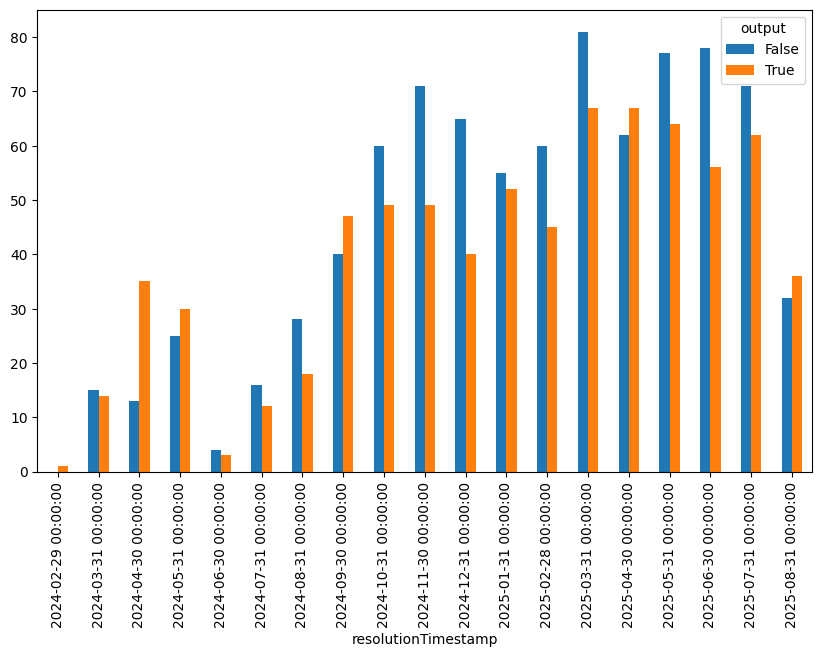

In [355]:
# group output counts by resolutionTimestamp week and plot as bar chart
fig, ax = plt.subplots(figsize=(10, 6))
df2.groupby(pd.Grouper(key='resolutionTimestamp', freq='m'))['output'].value_counts().unstack().plot(kind='bar', stacked=False, ax=ax)


In [362]:
grouped_df = df2.groupby(pd.Grouper(key='resolutionTimestamp', freq='m'))['output'].value_counts()
# crete a new column that is the percentage of False vs total counts

In [365]:
totals = grouped_df.groupby(level=0).sum()

# Now calculate the percentages
percentages = (grouped_df / totals * 100).round(2)

# To make it more readable, you can unstack the result
result = percentages.unstack()
result.columns = ['% False', '% True']

# If you want to include the counts as well
result[['Count_False', 'Count_True']] = grouped_df.unstack()
result['pct'] = result['Count_False'] / (result['Count_False'] + result['Count_True'])
# grou

<Axes: xlabel='resolutionTimestamp'>

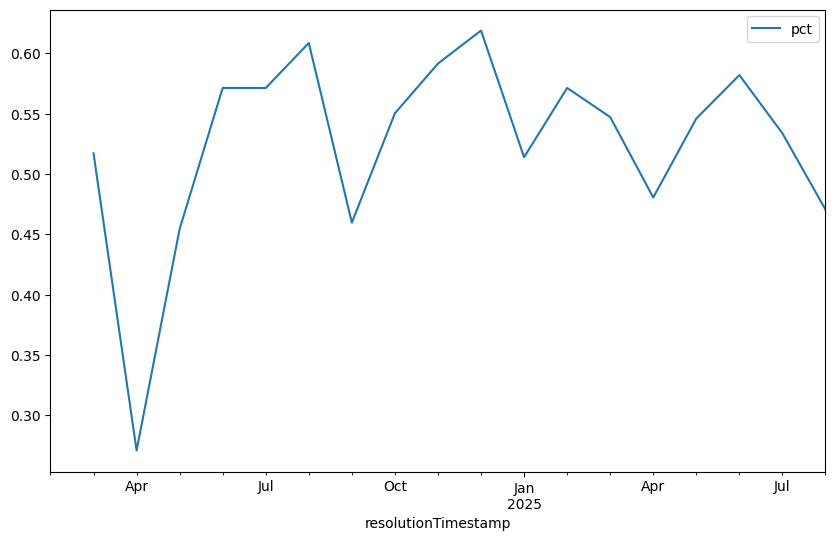

In [369]:
# plot result per month
fig, ax = plt.subplots(figsize=(10, 6))
result.plot(kind='line', y='pct',stacked=False, ax=ax)

In [ ]:
result